In [14]:
# import pandas as pd

# # df_ = pd.read_excel("Total.xlsx", index_col=None)

# df = pd.ExcelFile("Total.xlsx")
# print(df.sheet_names)
# df1 = pd.read_excel(df, '1st')
# df2 = pd.read_excel(df, '2nd')
# df3 = pd.read_excel(df, '3rd')
# df_ = pd.concat([df1,df2,df3],axis=0)

# cluster = df_['Cluster'].str.split(' ', n=1, expand=True)
# cluster = cluster.rename(columns={0:'cluster', 1:'kPa'})
# features = df_.drop('Cluster', axis=1)

# df_ = pd.concat([features, cluster], axis=1)
# df_.reset_index(drop=True, inplace=True)
# df_.to_csv('Total.csv', index=False)
# print(df_)

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

df = pd.read_csv('Total.csv', index_col = None)


df_ = df[df['kPa']=='22kPa']
X = df_.drop(["ID", "cluster","kPa"], axis=1) # Independent variables
# X = X.iloc[:,feature_selected]
y_ = df_.cluster # Dependent variable

y = np.zeros(y_.shape)
y[y_=='TIF'] = 1
y = pd.DataFrame(y, columns=['cluster'], dtype=float)
# y_.loc[y_=='CAF'] = 0
# y_.loc[y_=='TIF'] = 1
# y = y_.astype(float)

features = X.columns

# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [61]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train.iloc[:,:] = scaler.transform(X_train)
X_test.iloc[:,:] = scaler.transform(X_test)

X_train.shape


import shap
from sklearn.metrics import classification_report

# Random Forest

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Score of RF model on test split
 0.8888888888888888
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90        63
         1.0       0.89      0.87      0.88        54

    accuracy                           0.89       117
   macro avg       0.89      0.89      0.89       117
weighted avg       0.89      0.89      0.89       117



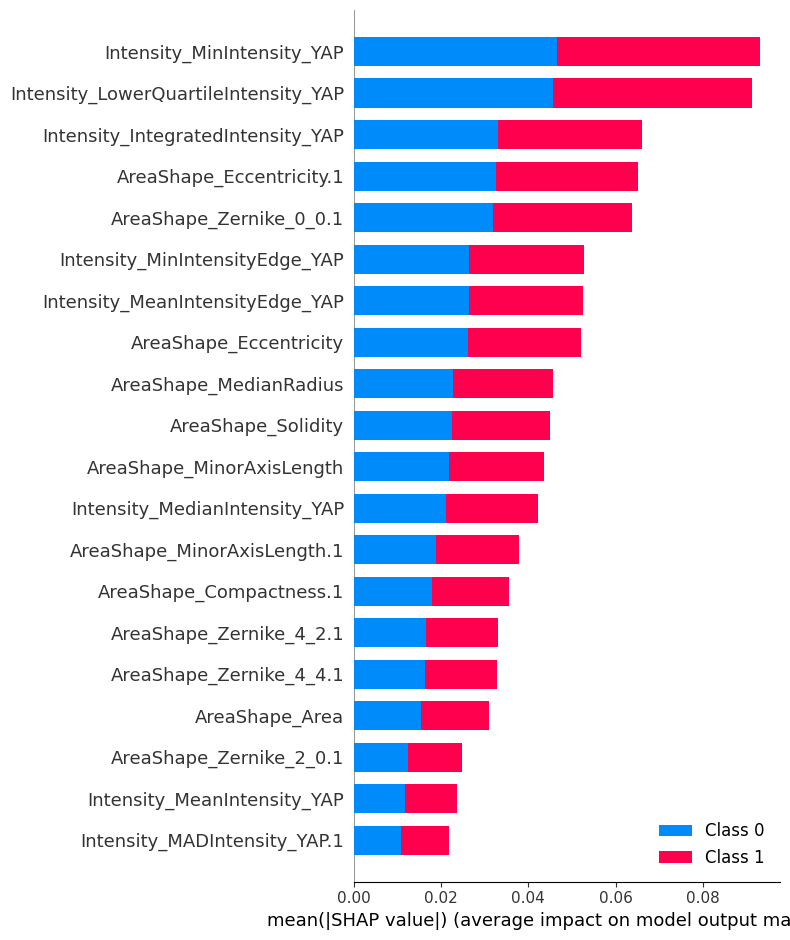

In [62]:

from sklearn.ensemble import RandomForestClassifier
shap.initjs()

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = clf.predict(X_test)


print('Score of RF model on test split\n',clf.score(X_test,y_test))
# Classification Report
print(classification_report(y_pred, y_test))

explainer = shap.Explainer(clf, X_train)
shap_values = explainer.shap_values(X_test)
# shap_values = shap_values.transpose(2,0,1)

# https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [63]:
ind = np.argsort((np.abs(shap_values[0])+np.abs(shap_values[1])).mean(axis=0))[-10:][::-1]
top10_RF = features[ind], ind
top10_RF

(Index(['Intensity_MinIntensity_YAP', 'Intensity_LowerQuartileIntensity_YAP',
        'Intensity_IntegratedIntensity_YAP', 'AreaShape_Eccentricity.1',
        'AreaShape_Zernike_0_0.1', 'Intensity_MinIntensityEdge_YAP',
        'Intensity_MeanIntensityEdge_YAP', 'AreaShape_Eccentricity',
        'AreaShape_MedianRadius', 'AreaShape_Solidity'],
       dtype='object'),
 array([ 6,  1,  0, 16, 18,  5,  2,  9, 10, 13]))

In [64]:

std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)

ind = np.argsort(clf.feature_importances_)[-10:][::-1]

top10_RF_1 = feature_importances[ind], ind
top10_RF_1
# fig, ax = plt.subplots()
# feature_importances[ind].plot.bar(yerr=std[ind], ax=ax)
# ax.set_title("Feature importances Random Forest Clf")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()
# plt.show()



(Intensity_LowerQuartileIntensity_YAP    0.099990
 Intensity_MeanIntensityEdge_YAP         0.072415
 Intensity_MinIntensity_YAP              0.065359
 AreaShape_Zernike_0_0.1                 0.062222
 Intensity_MinIntensityEdge_YAP          0.061720
 AreaShape_Eccentricity.1                0.051612
 AreaShape_MedianRadius                  0.048645
 AreaShape_Eccentricity                  0.046886
 Intensity_IntegratedIntensity_YAP       0.044331
 Intensity_MedianIntensity_YAP           0.043191
 dtype: float64,
 array([ 1,  2,  6, 18,  5, 16, 10,  9,  0,  4]))

In [66]:

from sklearn.ensemble import GradientBoostingClassifier

cgf= GradientBoostingClassifier(n_estimators=100,random_state=1200)
cgf.fit(X_train,y_train)

feature_importances = pd.Series(cgf.feature_importances_, index=X_train.columns)

print('Score of Gradient Boosting model on test split\n',cgf.score(X_test,y_test))


ind = np.argsort(cgf.feature_importances_)[-10:][::-1]
top10_GB_1 = feature_importances[ind], ind
top10_GB_1

# fig, ax = plt.subplots()
# feature_importances[ind].plot.bar(ax=ax)
# ax.set_title("Feature importances Gradient Boosting Clf")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()
# plt.show()

Score of Gradient Boosting model on test split
 0.8717948717948718


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


(Intensity_LowerQuartileIntensity_YAP    0.172940
 Intensity_MeanIntensityEdge_YAP         0.122122
 Intensity_IntegratedIntensity_YAP       0.110883
 AreaShape_Eccentricity.1                0.091916
 AreaShape_MedianRadius                  0.078025
 Intensity_MinIntensityEdge_YAP          0.070443
 AreaShape_Eccentricity                  0.054537
 Intensity_MinIntensity_YAP              0.053541
 AreaShape_Zernike_0_0.1                 0.053509
 AreaShape_Area                          0.053037
 dtype: float64,
 array([ 1,  2,  0, 16, 10,  5,  9,  6, 18,  8]))

# XGBOOST

              precision    recall  f1-score   support

       False       0.83      0.84      0.83        63
        True       0.81      0.80      0.80        54

    accuracy                           0.82       117
   macro avg       0.82      0.82      0.82       117
weighted avg       0.82      0.82      0.82       117



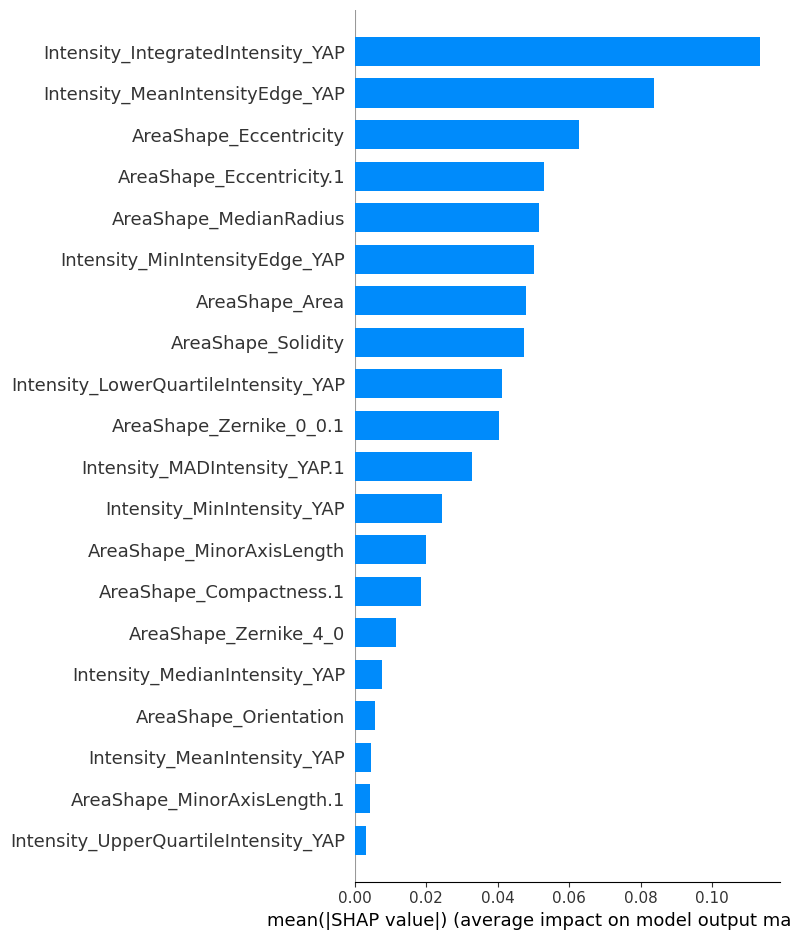

In [67]:
import xgboost

import shap

# train an XGBoost model
model = xgboost.XGBRegressor().fit(X_train, y_train)

# explainer = shap.Explainer(model)
# shap_values = explainer(X_train)


# Classification Report
y_pred = model.predict(X_test)
print(classification_report(y_pred>.5, y_test))

explainer = shap.Explainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, X_test, plot_type='bar')


In [68]:
ind = np.argsort(np.abs(shap_values).mean(axis=0))[-10:][::-1]
top10_XGB = features[ind], ind
top10_XGB


(Index(['Intensity_IntegratedIntensity_YAP', 'Intensity_MeanIntensityEdge_YAP',
        'AreaShape_Eccentricity', 'AreaShape_Eccentricity.1',
        'AreaShape_MedianRadius', 'Intensity_MinIntensityEdge_YAP',
        'AreaShape_Area', 'AreaShape_Solidity',
        'Intensity_LowerQuartileIntensity_YAP', 'AreaShape_Zernike_0_0.1'],
       dtype='object'),
 array([ 0,  2,  9, 16, 10,  5,  8, 13,  1, 18]))

In [69]:
import xgboost
import shap

d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)



In [70]:
np.array(y_train).mean()

0.4264705882352941

In [71]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.array(y_train).mean(),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)




[0]	test-logloss:0.68622
[100]	test-logloss:0.44748
[200]	test-logloss:0.35534
[300]	test-logloss:0.31091
[400]	test-logloss:0.28870
[500]	test-logloss:0.27762
[600]	test-logloss:0.27236
[602]	test-logloss:0.27214


In [72]:
y_pred = model.predict(d_test)
print(classification_report(y_pred>.5, y_test))
# xgboost.plot_importance(model)

              precision    recall  f1-score   support

       False       0.86      0.87      0.87        63
        True       0.85      0.83      0.84        54

    accuracy                           0.85       117
   macro avg       0.85      0.85      0.85       117
weighted avg       0.85      0.85      0.85       117



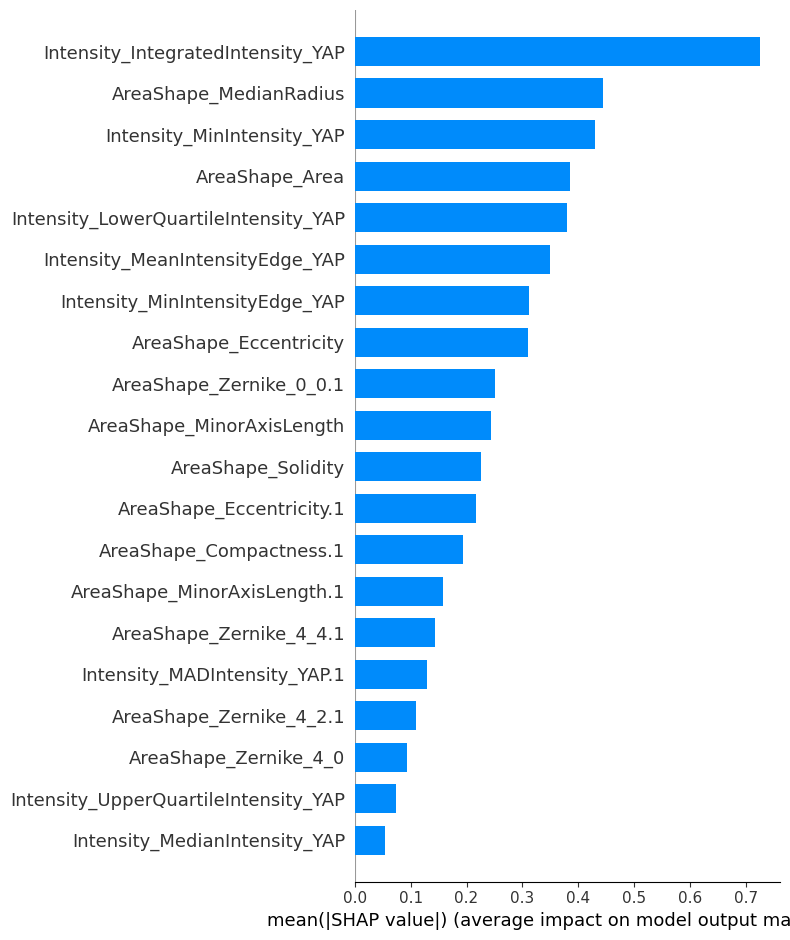

In [73]:

# Classification Report
# print(classification_report(y_pred, y_test))

explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [74]:
ind = np.argsort(np.abs(shap_values).mean(axis=0))[-10:][::-1]
top10_XGB_1 = features[ind], ind
top10_XGB_1

(Index(['Intensity_IntegratedIntensity_YAP', 'AreaShape_MedianRadius',
        'Intensity_MinIntensity_YAP', 'AreaShape_Area',
        'Intensity_LowerQuartileIntensity_YAP',
        'Intensity_MeanIntensityEdge_YAP', 'Intensity_MinIntensityEdge_YAP',
        'AreaShape_Eccentricity', 'AreaShape_Zernike_0_0.1',
        'AreaShape_MinorAxisLength'],
       dtype='object'),
 array([ 0, 10,  6,  8,  1,  2,  5,  9, 18, 11]))

In [75]:
# ## Adaptive Boost
# from sklearn import datasets
# from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
# import shap

# model = AdaBoostClassifier(random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# print(classification_report(y_pred>.5, y_test))


# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)

# # visualize the first prediction's explanation
# # shap.plots.waterfall(shap_values[0])
# # shap.summary_plot(shap_values, X_test, plot_type='bar')

# Logistic regression

In [76]:


# import seaborn as sns
# sns.pairplot(X_train, hue="price_range", height=2.5)

In [77]:
import sklearn

model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.76      0.92      0.83        64
         1.0       0.87      0.64      0.74        53

    accuracy                           0.79       117
   macro avg       0.81      0.78      0.79       117
weighted avg       0.81      0.79      0.79       117



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


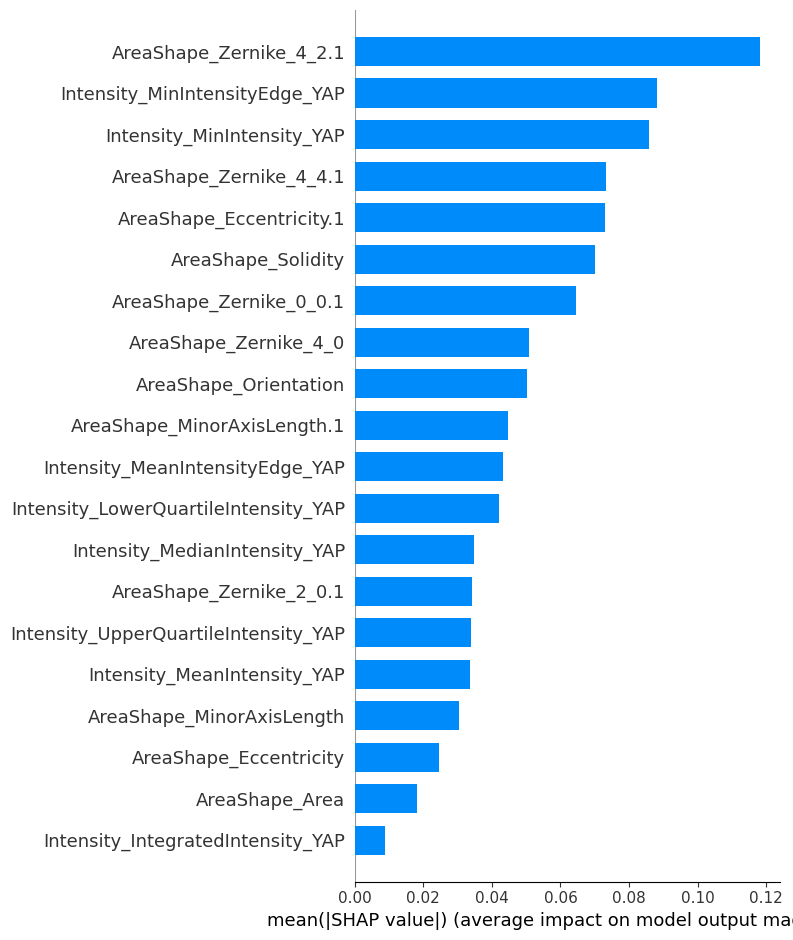

In [78]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
# shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [79]:
ind = np.argsort(np.abs(shap_values.values).mean(axis=0))[-10:][::-1]
top10_LR = features[ind], ind
top10_LR

(Index(['AreaShape_Zernike_4_2.1', 'Intensity_MinIntensityEdge_YAP',
        'Intensity_MinIntensity_YAP', 'AreaShape_Zernike_4_4.1',
        'AreaShape_Eccentricity.1', 'AreaShape_Solidity',
        'AreaShape_Zernike_0_0.1', 'AreaShape_Zernike_4_0',
        'AreaShape_Orientation', 'AreaShape_MinorAxisLength.1'],
       dtype='object'),
 array([20,  5,  6, 21, 16, 13, 18, 14, 12, 17]))

In [80]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test)))

testShap = 1000
explainers = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, testShap))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Using 272 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82        64
         1.0       0.80      0.74      0.76        53

    accuracy                           0.79       117
   macro avg       0.80      0.79      0.79       117
weighted avg       0.79      0.79      0.79       117



  0%|          | 0/117 [00:00<?, ?it/s]

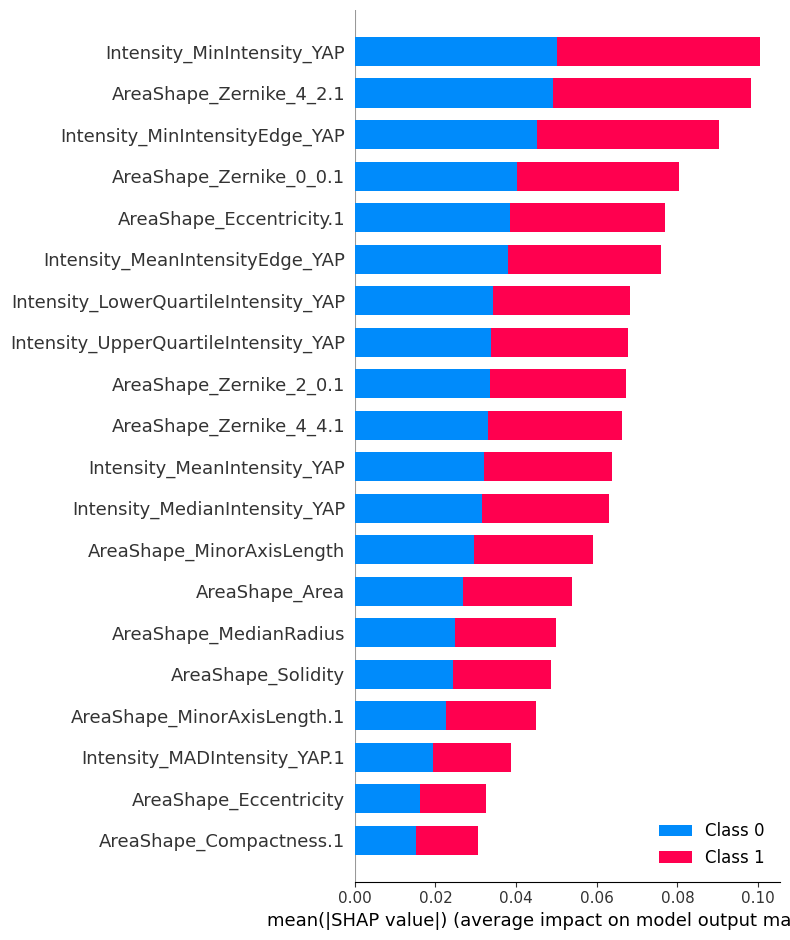

In [81]:
shap_values = explainers.shap_values(X_test)
# shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [82]:
ind = np.argsort((np.abs(shap_values[0])+np.abs(shap_values[1])).mean(axis=0))[-10:][::-1]
top10_NB = features[ind], ind
top10_NB

(Index(['Intensity_MinIntensity_YAP', 'AreaShape_Zernike_4_2.1',
        'Intensity_MinIntensityEdge_YAP', 'AreaShape_Zernike_0_0.1',
        'AreaShape_Eccentricity.1', 'Intensity_MeanIntensityEdge_YAP',
        'Intensity_LowerQuartileIntensity_YAP',
        'Intensity_UpperQuartileIntensity_YAP', 'AreaShape_Zernike_2_0.1',
        'AreaShape_Zernike_4_4.1'],
       dtype='object'),
 array([ 6, 20,  5, 18, 16,  2,  1,  7, 19, 21]))

In [52]:
np.array([[  2,   2,   2,  84,   1,  10,  11],
       [  7,   7,   7,   7,  11,  11,  10],
       [ 11,  11,  84,  43,   7, 105,  84],
       [ 10,  10,  11,  30,   2,  43,  98],
       [  9,   9,  10,   2,  38,  84, 105],
       [ 84,  84,   1,  10,  10, 106,   7],
       [ 94,   8,  38, 131,  20,  41,   2],
       [ 98,  98,  98,   1,  98,  98, 100],
       [  8,  94,  30,  11,  84,  50,  40],
       [ 40,  14,  20,  82,  82,   2,  14]])

array([[  2,   2,   2,  84,   1,  10,  11],
       [  7,   7,   7,   7,  11,  11,  10],
       [ 11,  11,  84,  43,   7, 105,  84],
       [ 10,  10,  11,  30,   2,  43,  98],
       [  9,   9,  10,   2,  38,  84, 105],
       [ 84,  84,   1,  10,  10, 106,   7],
       [ 94,   8,  38, 131,  20,  41,   2],
       [ 98,  98,  98,   1,  98,  98, 100],
       [  8,  94,  30,  11,  84,  50,  40],
       [ 40,  14,  20,  82,  82,   2,  14]])

In [83]:
feature_selected = np.c_[top10_RF[1], top10_RF_1[1], top10_GB_1[1], top10_XGB[1], top10_XGB_1[1], top10_LR[1], top10_NB[1]]
feature_selected = np.unique(feature_selected)
feature_selected

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21])

In [2]:
feature_selected = np.array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21])

In [3]:
features[feature_selected]

Index(['Intensity_IntegratedIntensityEdge_YAP',
       'Intensity_IntegratedIntensity_YAP',
       'Intensity_LowerQuartileIntensity_YAP',
       'Intensity_MassDisplacement_YAP', 'Intensity_MaxIntensityEdge_YAP',
       'Intensity_MaxIntensity_YAP', 'Intensity_MeanIntensityEdge_YAP',
       'Intensity_MeanIntensity_YAP', 'Intensity_MedianIntensity_YAP',
       'Intensity_MinIntensityEdge_YAP', 'Intensity_MinIntensity_YAP',
       'Intensity_StdIntensityEdge_YAP', 'Intensity_StdIntensity_YAP',
       'Intensity_UpperQuartileIntensity_YAP',
       'Location_CenterMassIntensity_Y_YAP', 'Location_MaxIntensity_X_YAP',
       'Location_MaxIntensity_Y_YAP', 'Math_logNucbyCyto', 'AreaShape_Area',
       'AreaShape_BoundingBoxArea'],
      dtype='object')

In [22]:
X = df_.drop(["ID", "cluster","kPa"], axis=1)
# xyz = X.iloc[:,feature_selected]

xyz = X.iloc[:, np.unique(np.array([[  2,   2,   2,  84,   1,  10,  11],
       [  7,   7,   7,   7,  11,  11,  10],
       [ 11,  11,  84,  43,   7, 105,  84],
       [ 10,  10,  11,  30,   2,  43,  98]]))]

In [23]:
corr_matrix = np.corrcoef(np.array(xyz).T).round(decimals=2)

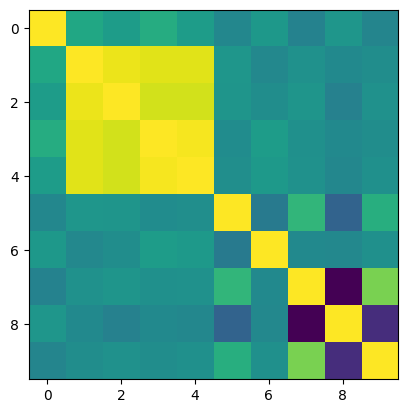

In [24]:
plt.imshow(corr_matrix)

In [25]:
np.unique(np.array([[  2,   2,   2,  84,   1,  10,  11],
       [  7,   7,   7,   7,  11,  11,  10],
       [ 11,  11,  84,  43,   7, 105,  84],
       [ 10,  10,  11,  30,   2,  43,  98]]))

array([  1,   2,   7,  10,  11,  30,  43,  84,  98, 105])

In [26]:
features[[2,   7,  10,  11]]

Index(['Intensity_LowerQuartileIntensity_YAP',
       'Intensity_MeanIntensityEdge_YAP', 'Intensity_MinIntensityEdge_YAP',
       'Intensity_MinIntensity_YAP'],
      dtype='object')

In [30]:
features[[30, 84,  98, 105]]

Index(['AreaShape_Eccentricity', 'AreaShape_Eccentricity.1',
       'AreaShape_Zernike_0_0.1', 'AreaShape_Zernike_4_2.1'],
      dtype='object')